# Datasette Tutorial

This notebook walks through the key features of **Datasette** for exploring and publishing SQLite data via a web interface, JSON API, and interactive visualizations. We'll cover:
1. Installation & plugins
2. Serving a database
3. Exploring the web UI & JSON API
4. Metadata customization (queries, dashboards, CSS)
5. Vega‑Lite charts (`datasette-vega`)
6. Cluster maps (`datasette-cluster-map`)
7. Pretty‑printed JSON (`datasette-json-html`)
8. Next steps & further resources


## 1. Installation

Install Datasette and recommended plugins:

In [1]:
!pip install datasette datasette-vega datasette-cluster-map datasette-json-html


## 2. Serving a SQLite Database

Assuming you have `data/bitcoin_data.db` in your working directory:

In [2]:
!datasette serve data/bitcoin_data.db --host 127.0.0.1 --port 8002 --metadata metadata.json


INFO:     Started server process [75]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8002 (Press CTRL+C to quit)
^C
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [75]


## 3. Exploring the Web UI & JSON API

- Navigate to http://127.0.0.1:8002 in your browser
- Click tables to browse records
- Append `.json` to any URL to get JSON (e.g., `/bitcoin_data/bitcoin_prices.json`).

## 4. Metadata Customization

Use a `metadata.json` to define:
- **Queries**: canned SQL snippets
- **Dashboards**: prebuilt charts
- **Custom CSS**

Example snippet:
```json
"queries": { "recent": { "sql": "SELECT * FROM bitcoin_prices LIMIT 10", "title": "Recent" } }
```

## 5. Vega‑Lite Charts

With `datasette-vega`, you can define charts in metadata queries:

Add to metadata.json

yq -i '.databases.bitcoin_data.queries.recent_prices.display = {chart: "line", x: "timestamp", y: "price"}' metadata.json


## 6. Cluster Maps

`datasette-cluster-map` lets you visualize geo-coordinates on a map. Define a query that returns `latitude` and `longitude`. Example:
```json
"queries": { "locations": { "sql": "SELECT lat, lon FROM my_table", "title": "Map View" } }
```

## 7. Pretty‑printed JSON

`datasette-json-html` will render JSON in a more human‑friendly way in the browser. No extra config needed once installed.

## 8. Next Steps & Further Reading

- [Datasette Documentation](https://docs.datasette.io)
- Writing custom plugins
- Deploying with Docker or Vercel
- Using Datasette Cloud


## Exploring the CoinGecko API
#
In this section we’ll walk through some of the key features of the CoinGecko API:
1. **No API Key Required** — It’s completely open and free for most use-cases.  
2. **Wide Coin Coverage** — Access data on thousands of cryptocurrencies.  
3. **Realtime Prices & Market Data** — Get current prices, market caps, trading volumes.  
4. **Historical Data** — Fetch past market charts (e.g. 30-day price history).  
5. **Global Metrics** — Retrieve aggregated crypto market statistics.  


In [4]:

### 1. Installation & Setup
#
# We’ll use the `requests` library to call the REST API.
# You can install it via pip if you haven’t already:
#
# ```bash
# pip install requests
# ```
# %%
import requests

# Base URL for CoinGecko REST API
BASE_URL = "https://api.coingecko.com/api/v3"



### 2. List Supported Coins
#
Retrieve a list of all coins that CoinGecko tracks. This lets us find the `id` we need for subsequent calls.


In [5]:
# %%
resp = requests.get(f"{BASE_URL}/coins/list")
coins = resp.json()

# Show the first 5 coins
coins[:5]

[{'id': '_', 'symbol': 'gib', 'name': '༼ つ ◕_◕ ༽つ'},
 {'id': '000-capital', 'symbol': '000', 'name': '000 Capital'},
 {'id': '01coin', 'symbol': 'zoc', 'name': '01coin'},
 {'id': '0chain', 'symbol': 'zcn', 'name': 'Zus'},
 {'id': '0dog', 'symbol': '0dog', 'name': 'Bitcoin Dogs'}]


### 3. Fetch Current Price
#
Use a coin’s `id` (e.g. `"bitcoin"`) to get its current price in multiple currencies.


In [6]:
# %%
params = {
    "ids": "bitcoin,ethereum",
    "vs_currencies": "usd,eur,gbp",
    "include_market_cap": "true",
    "include_24hr_vol": "true",
}
resp = requests.get(f"{BASE_URL}/simple/price", params=params)
resp.json()


{'bitcoin': {'usd': 103012,
  'usd_market_cap': 2046164579173.4417,
  'usd_24h_vol': 23427286705.609165,
  'eur': 92288,
  'eur_market_cap': 1833140431000.275,
  'eur_24h_vol': 20988295313.974895,
  'gbp': 77552,
  'gbp_market_cap': 1540438634114.093,
  'gbp_24h_vol': 17637045378.024216},
 'ethereum': {'usd': 2484.47,
  'usd_market_cap': 299817434112.9891,
  'usd_24h_vol': 18341515911.402756,
  'eur': 2225.81,
  'eur_market_cap': 268603740864.91992,
  'eur_24h_vol': 16431999031.382523,
  'gbp': 1870.41,
  'gbp_market_cap': 225715156732.4909,
  'gbp_24h_vol': 13808263521.772272}}


### 4. Historical Market Chart
#
Retrieve the last 30 days of price data for Bitcoin. Response includes timestamps and price points suitable for plotting.


In [7]:

params = {
    "vs_currency": "usd",
    "days": "30",
    "interval": "daily"
}
resp = requests.get(f"{BASE_URL}/coins/bitcoin/market_chart", params=params)
chart_data = resp.json()["prices"]

# Convert to DataFrame for convenience
import pandas as pd
df = pd.DataFrame(chart_data, columns=["timestamp", "price"])
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df.set_index("timestamp", inplace=True)
df.head()


,price
timestamp,
2025-04-18,84930.908576
2025-04-19,84433.750172
2025-04-20,85126.662443
2025-04-21,85073.165449
2025-04-22,87452.046991



### Plotting the 30-Day Price History
#
Let’s visualize Bitcoin’s daily closing price over the last month.


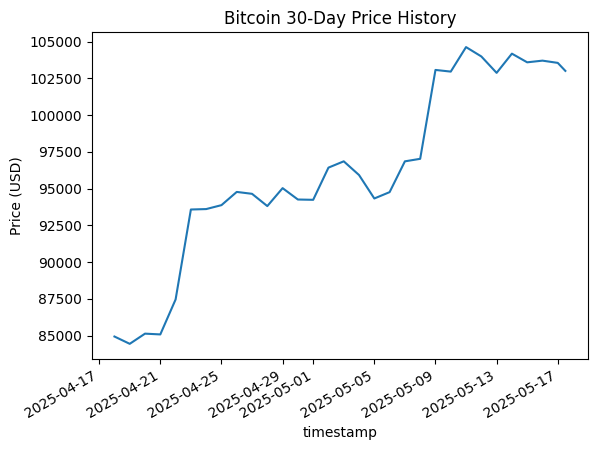

In [8]:
# %%
import matplotlib.pyplot as plt

df["price"].plot(title="Bitcoin 30-Day Price History", ylabel="Price (USD)")
plt.show()


### 5. Global Crypto Market Data
#
Fetch overall market statistics, such as total market cap and 24h trading volume.


In [9]:
# %%
resp = requests.get(f"{BASE_URL}/global")
global_stats = resp.json()["data"]
pd.Series(global_stats).loc[[
    "active_cryptocurrencies",
    "upcoming_icos",
    "total_market_cap",
    "total_volume",
    "market_cap_percentage"
]]


active_cryptocurrencies                                                17066
upcoming_icos                                                              0
total_market_cap           {'btc': 32900048.75150984, 'eth': 1365346947.7...
total_volume               {'btc': 938965.8600696438, 'eth': 38966938.340...
market_cap_percentage      {'btc': 60.38073119599359, 'eth': 8.8399399517...
dtype: object


### Next Steps
 - Experiment with other endpoints (e.g. `/coins/{id}/ohlc`, `/exchanges`, `/derivatives`).  
 - Combine live data pulls with your SQLite database ingestion.  
 - Incorporate these calls into `bitcoin_utils.py` so the notebook can update your dataset seamlessly.


In [ ]:
# Bitcoin.API.ipynb

# 📘 Section 1: Import Required Libraries
from bitcoin_utils import (
    fetch_historical_bitcoin_prices,
    fetch_current_price,
    save_to_sqlite,
    init_db
)
import pandas as pd
import sqlite3


In [ ]:
# 📘 Section 2: Initialize SQLite Database

# Create the database and ensure the bitcoin_prices table exists
init_db()
print("Database initialized.")


Database initialized.


In [3]:
# 📘 Section 3: Fetch Historical Bitcoin Prices

# Get the last 365 days of Bitcoin daily prices
historical_df = fetch_historical_bitcoin_prices(days=365, interval="daily")
historical_df.head()


,timestamp,price
0,2024-05-12,60776.972079
1,2024-05-13,61507.054004
2,2024-05-14,62878.783301
3,2024-05-15,61569.113006
4,2024-05-16,66220.518314


In [4]:
# 📘 Section 4: Save Historical Data to SQLite

save_to_sqlite(historical_df, db_file="data/bitcoin_data.db")
print("Historical data saved.")


Historical data saved.


In [5]:
# 📘 Section 5: Fetch Real-Time Bitcoin Price

# This returns the current price with a UTC timestamp
current_df = fetch_current_price()
current_df


,timestamp,price
0,2025-05-11 21:57:20.613604+00:00,104238


In [6]:
# 📘 Section 6: Save Real-Time Price to SQLite

save_to_sqlite(current_df, db_file="data/bitcoin_data.db")
print("Current price saved.")


Current price saved.


In [7]:
# 📘 Section 7: Verify Data Was Saved

# Connect to the database and query latest rows
conn = sqlite3.connect("data/bitcoin_data.db")
query_df = pd.read_sql_query("SELECT * FROM bitcoin_prices ORDER BY timestamp DESC LIMIT 5", conn)
conn.close()
query_df


,id,timestamp,price
0,733,2025-05-11 21:57:20.613604+00:00,104238.000000
1,732,2025-05-11 21:54:25,104199.093282
2,731,2025-05-11 00:00:00,104630.879299
3,730,2025-05-10 00:00:00,102962.540457
4,729,2025-05-09 00:00:00,103076.275555
